Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [5]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "/Users/lorna/master2/cs445/proj5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
#samplesfn = datadir + "samples"
#!cp -r "$samplesfn" .
import utils

cp: ./utils.py and /Users/lorna/master2/cs445/proj5/utils.py are identical (not copied).


### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [8]:
def score_projection(pt1, pt2):
    dists = np.linalg.norm(pt1 - pt2, axis=0)
    threshold = 5.0
    inliers = dists < threshold
    score = np.sum(inliers)
    return score, inliers

def computeHomography(pts1, pts2, normalization_func=None):
    N = pts1.shape[1]
    A = []
    for i in range(N):
        X = pts1[:, i]
        x, y, w = pts2[:, i]
        A.append([0, 0, 0, -w*X[0], -w*X[1], -w*X[2], y*X[0], y*X[1], y*X[2]])
        A.append([w*X[0], w*X[1], w*X[2], 0, 0, 0, -x*X[0], -x*X[1], -x*X[2]])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]


RANSAC best inliers: 222 / 244
Recomputed H using all inliers.
Final H normalized: [[ 1.00000000e+00  4.19855291e-02 -2.04188576e+02]
 [ 1.13635129e-02  9.45765214e-01 -1.44281343e+01]
 [ 3.63969647e-04  2.99169598e-05  8.20840476e-01]]


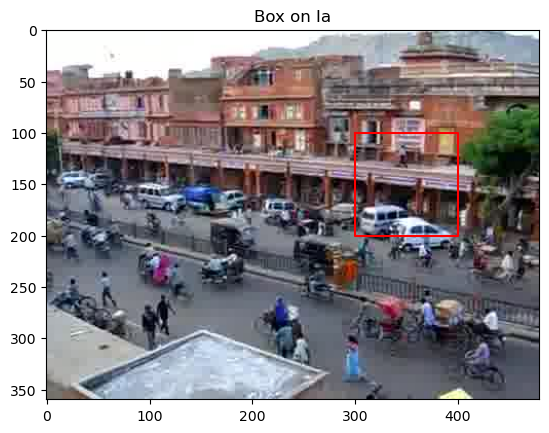

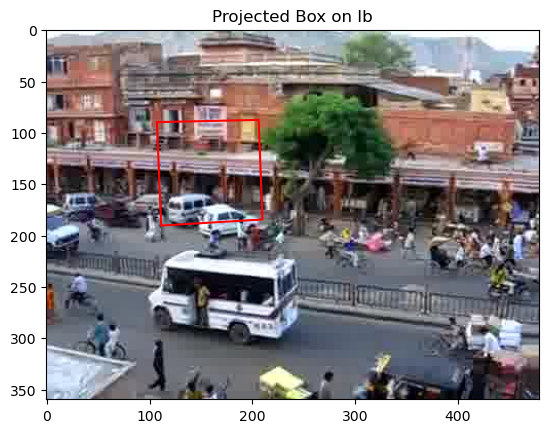

Saved stitched image to /Users/lorna/master2/cs445/proj5/images/input/frames/stitched_refined.png


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from random import random
import time
import scipy
import scipy.sparse.linalg

# Set paths
datadir = "/Users/lorna/master2/cs445/proj5/"
frame_dir = os.path.join(datadir, "images/input/frames/")

# Ensure utils is present
utilfn = os.path.join(datadir, "utils.py")
if not os.path.exists("utils.py"):
    shutil.copy(utilfn, ".")

# Copy samples directory if exists
samplesfn = os.path.join(datadir, "samples")
if os.path.exists(samplesfn):
    shutil.copytree(samplesfn, "./samples", dirs_exist_ok=True)

import utils


def score_projection(pt1, pt2, threshold=5.0):
    """
    Score inliers based on reprojection distance.
    pt1, pt2: 2xN arrays of projected vs. actual points.
    threshold: pixels.
    Returns count and boolean mask.
    """
    dists = np.linalg.norm(pt1 - pt2, axis=0)
    inliers = dists < threshold
    return np.sum(inliers), inliers


def computeHomography(pts1, pts2, normalization_func=None):
    """
    Solve H * pts1 = pts2 using DLT + SVD.
    pts1, pts2: 3xN homogeneous coordinates.
    """
    N = pts1.shape[1]
    A = []
    for i in range(N):
        X = pts1[:, i]
        x, y, w = pts2[:, i]
        A.append([0, 0, 0, -w*X[0], -w*X[1], -w*X[2], y*X[0], y*X[1], y*X[2]])
        A.append([w*X[0], w*X[1], w*X[2], 0, 0, 0, -x*X[0], -x*X[1], -x*X[2]])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]


def auto_homography(Ia, Ib, homography_func, thr=5.0, niter=2000, refine=True):
    """
    Compute homography Ia->Ib via RANSAC and optional refinement.
    thr: inlier threshold in pixels.
    niter: number of RANSAC iterations.
    refine: whether to re-estimate H using all inliers.
    """
    # Convert to gray
    Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp_a, des_a = sift.detectAndCompute(Ia_gray, None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a, des_b, k=2)
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]
    numMatches = len(good)

    # Build homogeneous correspondences
    Xa = np.ones((3, numMatches))
    Xb = np.ones((3, numMatches))
    for idx, m in enumerate(good):
        Xa[0:2, idx] = kp_a[m.queryIdx].pt
        Xb[0:2, idx] = kp_b[m.trainIdx].pt

    best_score = 0
    best_H = None
    best_inliers = None
    sample_size = 4

    for _ in range(niter):
        idxs = np.random.choice(numMatches, sample_size, replace=False)
        H_t = homography_func(Xa[:, idxs], Xb[:, idxs])
        Xb_proj = H_t @ Xa
        Xb_proj /= Xb_proj[2]
        score, inliers = score_projection(Xb[:2], Xb_proj[:2], threshold=thr)
        if score > best_score:
            best_score = score
            best_H = H_t
            best_inliers = inliers

    print(f"RANSAC best inliers: {best_score} / {numMatches}")

    # Refine H on all inliers
    if refine and best_inliers is not None and best_score >= sample_size:
        in_pts1 = Xa[:, best_inliers]
        in_pts2 = Xb[:, best_inliers]
        best_H = homography_func(in_pts1, in_pts2)
        print("Recomputed H using all inliers.")

    return best_H


def plot_projection(Ia, Ib, H):
    # Define a test square in Ia
    box = np.array([[300,400,400,300,300], [100,100,200,200,100], [1,1,1,1,1]])
    # Plot on Ia
    plt.figure(); plt.imshow(Ia[:,:,::-1]); plt.plot(box[0], box[1], 'r-'); plt.title('Box on Ia')
    # Project and plot on Ib
    box_proj = H @ box
    box_proj /= box_proj[2]
    plt.figure(); plt.imshow(Ib[:,:,::-1]); plt.plot(box_proj[0], box_proj[1], 'r-'); plt.title('Projected Box on Ib')
    plt.show()


def stitch_images(Ia, Ib, H, offset=(660,120), canvas_size=(1600,500)):
    Tr = np.array([[1,0,offset[0]], [0,1,offset[1]], [0,0,1]])
    warped = cv2.warpPerspective(Ia, Tr @ H, canvas_size)
    h, w = Ib.shape[:2]
    x0, y0 = offset
    warped[y0:y0+h, x0:x0+w] = Ib
    return warped


if __name__ == '__main__':
    # Load images
    im1 = cv2.imread(os.path.join(frame_dir, 'f0270.jpg'))
    im2 = cv2.imread(os.path.join(frame_dir, 'f0450.jpg'))

    # Tune threshold and iterations here
    H = auto_homography(im1, im2, computeHomography, thr=5.0, niter=2000, refine=True)
    print("Final H normalized:", H / H.max())

    # Visual check
    plot_projection(im1, im2, H)

    # Stitch and save
    result = stitch_images(im1, im2, H)
    out_path = os.path.join(frame_dir, 'stitched_refined.png')
    cv2.imwrite(out_path, result)
    print(f"Saved stitched image to {out_path}")


RANSAC best inliers: 221 / 244
Recomputed H using all inliers.
[[ 1.00000000e+00  4.45839350e-02 -2.04442116e+02]
 [ 1.14285827e-02  9.47103561e-01 -1.45672416e+01]
 [ 3.65089012e-04  3.58446780e-05  8.19940028e-01]]


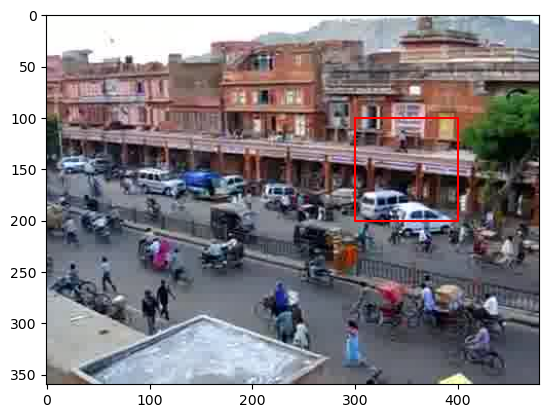

In [10]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2



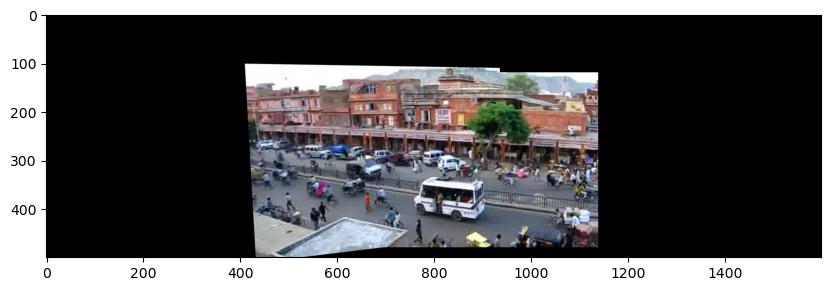

In [11]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])


T1 = Tr.dot(H)
T2 = Tr.astype(np.float32)
projIm1 = cv2.warpPerspective(im1, T1, (projectedWidth, projectedHeight))
projIm2 = cv2.warpPerspective(im2, T2, (projectedWidth, projectedHeight))
blendOut = utils.blendImages(projIm1, projIm2) 

plt.figure(figsize=(10,10))
plt.imshow(blendOut[:,:,[2,1,0]])



### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


In [13]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 1600
projectedHeight = 500

# First computer homographies between frames 270/630, and 450. frames[2] is f450, the central frame

H12 = auto_homography(frames[1],frames[2], computeHomography)
H32 = auto_homography(frames[3],frames[2], computeHomography)
H01 = auto_homography(frames[0],frames[1], computeHomography)
H43 = auto_homography(frames[4],frames[3], computeHomography)
H02 = np.dot(H01,H12)
H42 = np.dot(H43,H32)



RANSAC best inliers: 222 / 244
Recomputed H using all inliers.
RANSAC best inliers: 215 / 237
Recomputed H using all inliers.
RANSAC best inliers: 261 / 281
Recomputed H using all inliers.
RANSAC best inliers: 151 / 178
Recomputed H using all inliers.


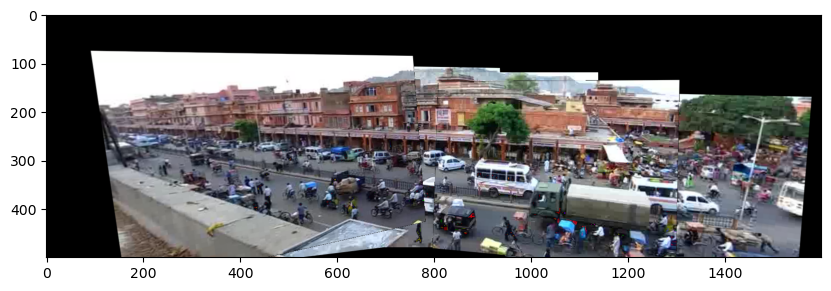

In [14]:
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)
T12 = Tr.dot(H12)
proj270 = cv2.warpPerspective(frames[1], T12, (projectedWidth, projectedHeight))
proj450 = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
blend1 = utils.blendImages(proj270, proj450) 

T32 = Tr.dot(H32)
proj630 = cv2.warpPerspective(frames[3], T32, (projectedWidth, projectedHeight))
blend2 = utils.blendImages(blend1, proj630) 

T02 = Tr.dot(H02)
proj90 = cv2.warpPerspective(frames[0], T02, (projectedWidth, projectedHeight)) 
blend3 = utils.blendImages(blend2, proj90)

T42 = Tr.dot(H42)
proj810 = cv2.warpPerspective(frames[4], T42, (projectedWidth, projectedHeight)) 

blend4 = utils.blendImages(proj810, blend3)

plt.figure(figsize=(10,10))
plt.imshow(blend4[:,:,[2,1,0]])

# plt.figure(figsize=(10,10))
# plt.imshow(blendOut[:,:,[2,1,0]])



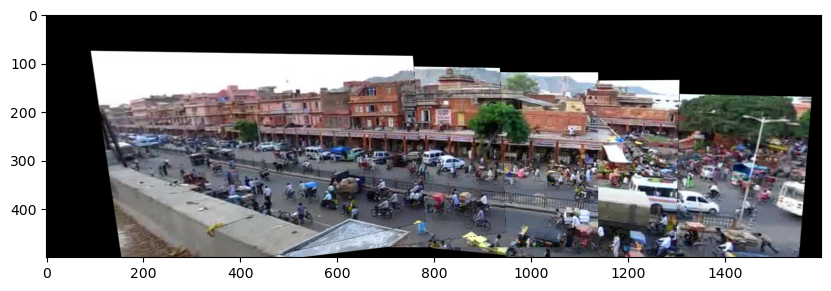

In [15]:


# Alternate method of making a panorama using a for loop

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)

projs = np.zeros((5, projectedHeight, projectedWidth, 3))
projs[0] = cv2.warpPerspective(frames[0], Tr.dot(H02), (projectedWidth, projectedHeight))
projs[1] = cv2.warpPerspective(frames[1], Tr.dot(H12), (projectedWidth, projectedHeight))
projs[2] = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
projs[3] = cv2.warpPerspective(frames[3], Tr.dot(H32), (projectedWidth, projectedHeight))
projs[4] = cv2.warpPerspective(frames[4], Tr.dot(H42), (projectedWidth, projectedHeight))

old_blend = projs[0]
for i in range(1,projs.shape[0]):
  blend = utils.blendImages(projs[i], old_blend)
  old_blend = blend

plt.figure(figsize=(10,10))
plt.imshow(blend[:,:,[2,1,0]])

# plt.figure(figsize=(10,10))
# plt.imshow(blendOut[:,:,[2,1,0]])


In [16]:
# Save your 5 key-frame-to-f450 homographies
Hs = [H02, H12, np.eye(3, dtype=np.float32), H32, H42]
np.save(os.path.join(datadir, "homographies.npy"), Hs)


### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [18]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)



In [19]:
# TO DO part 3 solution

# create your video (see tips)

In [20]:
H_key = np.zeros((key_frames_idx.shape[0],3,3))
H_key[1] = auto_homography(frames[270-1],frames[450-1], computeHomography) #H12
H_key[3] = auto_homography(frames[630-1],frames[450-1], computeHomography) #H32
H_key[0] = np.dot(auto_homography(frames[90-1],frames[270-1], computeHomography),H_key[1]) # 0 to 1, 1 to 2
H_key[4] = np.dot(auto_homography(frames[810-1],frames[630-1], computeHomography),H_key[3]) # 4 to 3, 3 to 2
H_key[2] = np.identity(3)

Hs = np.zeros((frameCount,3,3))
for f in range(frameCount): # f is frame number
  
  key_frame = np.argmin(np.abs(key_frames_idx - f))
  H_toKey = auto_homography(frames[f],frames[key_frames_idx[key_frame]], computeHomography)
  Hs[f] = np.dot(H_toKey,H_key[key_frame])

RANSAC best inliers: 222 / 244
Recomputed H using all inliers.
RANSAC best inliers: 215 / 237
Recomputed H using all inliers.
RANSAC best inliers: 260 / 281
Recomputed H using all inliers.
RANSAC best inliers: 151 / 178
Recomputed H using all inliers.
RANSAC best inliers: 429 / 446
Recomputed H using all inliers.
RANSAC best inliers: 429 / 446
Recomputed H using all inliers.
RANSAC best inliers: 453 / 473
Recomputed H using all inliers.
RANSAC best inliers: 443 / 464
Recomputed H using all inliers.
RANSAC best inliers: 462 / 492
Recomputed H using all inliers.
RANSAC best inliers: 450 / 478
Recomputed H using all inliers.
RANSAC best inliers: 481 / 509
Recomputed H using all inliers.
RANSAC best inliers: 457 / 489
Recomputed H using all inliers.
RANSAC best inliers: 476 / 508
Recomputed H using all inliers.
RANSAC best inliers: 495 / 523
Recomputed H using all inliers.
RANSAC best inliers: 494 / 520
Recomputed H using all inliers.
RANSAC best inliers: 480 / 509
Recomputed H using all i

/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/4283116995.py:94: RuntimeWarning: divide by zero encountered in divide
  Xb_proj /= Xb_proj[2]
/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/4283116995.py:94: RuntimeWarning: invalid value encountered in divide
  Xb_proj /= Xb_proj[2]


RANSAC best inliers: 312 / 344
Recomputed H using all inliers.
RANSAC best inliers: 309 / 340
Recomputed H using all inliers.
RANSAC best inliers: 313 / 342
Recomputed H using all inliers.
RANSAC best inliers: 333 / 357
Recomputed H using all inliers.
RANSAC best inliers: 344 / 367
Recomputed H using all inliers.
RANSAC best inliers: 339 / 369
Recomputed H using all inliers.
RANSAC best inliers: 361 / 373
Recomputed H using all inliers.
RANSAC best inliers: 326 / 355
Recomputed H using all inliers.
RANSAC best inliers: 313 / 341
Recomputed H using all inliers.
RANSAC best inliers: 299 / 319
Recomputed H using all inliers.
RANSAC best inliers: 310 / 342
Recomputed H using all inliers.
RANSAC best inliers: 340 / 366
Recomputed H using all inliers.
RANSAC best inliers: 319 / 343
Recomputed H using all inliers.
RANSAC best inliers: 301 / 329
Recomputed H using all inliers.
RANSAC best inliers: 366 / 397
Recomputed H using all inliers.
RANSAC best inliers: 326 / 351
Recomputed H using all i

In [144]:
Hs = np.load(datadir + "homographies.npy")


In [146]:
projectedWidth  = 1600
projectedHeight = 500
frameCount      = 900

Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# Suppose these were your five key frames and Hs was loaded/saved earlier:
key_frames = [90, 270, 450, 630, 810]     # frame numbers
# Hs is a length-5 array of 3×3 homographies in the same order
# Build a dict: frame_number -> H
homography_map = {frm: Hs[i] for i, frm in enumerate(key_frames)}

projected_frames = np.zeros((frameCount, projectedHeight, projectedWidth, 3), dtype=np.uint8)

for f in range(frameCount):
    fname = f"f0{str(f+1).zfill(3)}.jpg"
    img   = cv2.imread(os.path.join(frame_dir, fname))
    if img is None:
        continue
    
    H = homography_map.get(f+1, np.eye(3, dtype=np.float32))
    H_warp = Tr @ H
    projected_frames[f] = cv2.warpPerspective(img, H_warp, (projectedWidth, projectedHeight))


In [147]:
import cv2
import numpy as np
import os
import shutil
import utils

# --- Paths ---
datadir   = "/Users/lorna/master2/cs445/proj5/"
frame_dir = os.path.join(datadir, "images/input/frames/")
homography_file = os.path.join(datadir, "homographies.npy")

# --- RANSAC Homography Helpers ---
def score_projection(pt1, pt2, threshold=5.0):
    dists   = np.linalg.norm(pt1 - pt2, axis=0)
    inliers = dists < threshold
    return np.sum(inliers), inliers

def computeHomography(pts1, pts2):
    N = pts1.shape[1]
    A = []
    for i in range(N):
        X = pts1[:, i]
        x, y, w = pts2[:, i]
        A.append([0, 0, 0, -w*X[0], -w*X[1], -w*X[2],  y*X[0], y*X[1], y*X[2]])
        A.append([w*X[0], w*X[1], w*X[2], 0, 0, 0, -x*X[0], -x*X[1], -x*X[2]])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

def auto_homography(Ia, Ib, homography_func, thr=5.0, niter=1500, refine=True):
    Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)
    sift    = cv2.SIFT_create()
    kp_a, des_a = sift.detectAndCompute(Ia_gray, None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray, None)
    bf      = cv2.BFMatcher()
    matches = bf.knnMatch(des_a, des_b, k=2)
    good    = [m for m, n in matches if m.distance < 0.75*n.distance]
    num     = len(good)
    Xa = np.ones((3, num)); Xb = np.ones((3, num))
    for idx, m in enumerate(good):
        Xa[0:2, idx] = kp_a[m.queryIdx].pt
        Xb[0:2, idx] = kp_b[m.trainIdx].pt
    best_score = 0
    best_H = np.eye(3, dtype=np.float32)
    best_inliers = None
    for _ in range(niter):
        ids = np.random.choice(num, 4, replace=False)
        H_t = homography_func(Xa[:, ids], Xb[:, ids])
        Xb_proj = H_t @ Xa
        Xb_proj /= Xb_proj[2]
        score, inliers = score_projection(Xb[:2], Xb_proj[:2], threshold=thr)
        if score > best_score:
            best_score = score
            best_H = H_t
            best_inliers = inliers
    print(f"RANSAC inliers: {best_score}/{num}")
    if refine and best_inliers is not None and best_score >= 4:
        best_H = homography_func(Xa[:, best_inliers], Xb[:, best_inliers])
        print("Refined H with all inliers.")
    return best_H.astype(np.float32)

# --- Key Frames ---
key_frames = [90, 270, 450, 630, 810]  # frame numbers

# --- Load or compute homographies ---
if os.path.exists(homography_file):
    print("Loading cached homographies...")
    Hs_raw = np.load(homography_file, allow_pickle=True)
    # ensure numeric dtype
    Hs = [np.array(H, dtype=np.float32) for H in Hs_raw]
else:
    print("Computing homographies to reference frame 450...")
    # Load the five key frames
    frames_k = []
    for k in key_frames:
        fname = f"f{k:04d}.jpg"
        img = cv2.imread(os.path.join(frame_dir, fname))
        if img is None:
            raise FileNotFoundError(f"Cannot find {fname}")
        frames_k.append(img)
    ref_frame = frames_k[2]
    Hs = []
    for img in frames_k:
        if img is ref_frame:
            Hs.append(np.eye(3, dtype=np.float32))
        else:
            H = auto_homography(img, ref_frame, computeHomography)
            Hs.append(H)
    Hs = [H.astype(np.float32) for H in Hs]
    np.save(homography_file, Hs)
    print("Homographies saved.")

# --- Build lookup dict ---
if len(Hs) != len(key_frames):
    raise RuntimeError(f"Expected {len(key_frames)} homographies but got {len(Hs)}")
homography_map = {frm: H for frm, H in zip(key_frames, Hs)}

# --- Warp all frames ---
projectedWidth = 1600
projectedHeight = 500
frameCount = 900
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float32)
projected_frames = np.zeros((frameCount, projectedHeight, projectedWidth, 3), dtype=np.uint8)

for f in range(frameCount):
    frame_number = f + 1
    fname = f"f{frame_number:04d}.jpg"
    img = cv2.imread(os.path.join(frame_dir, fname))
    if img is None:
        continue
    H = homography_map.get(frame_number, np.eye(3, dtype=np.float32))
    H_warp = Tr @ H  # numeric float32
    projected_frames[f] = cv2.warpPerspective(img, H_warp, (projectedWidth, projectedHeight))

print("All frames warped into `projected_frames` array.")


Loading cached homographies...
All frames warped into `projected_frames` array.


In [149]:
# 1) Save the full array if you want
np.save(os.path.join(datadir, "projections.npy"), projected_frames)

# 2) Dump each warped frame into a folder
warped_dir = os.path.join(datadir, "warped")
os.makedirs(warped_dir, exist_ok=True)

for i in range(frameCount):
    out_name = os.path.join(warped_dir, f"a{i+1:04d}.jpg")
    cv2.imwrite(out_name, projected_frames[i])

# 3) Ensure your results folder exists
results_dir = os.path.join(datadir, "results")
os.makedirs(results_dir, exist_ok=True)

# 4) Encode to MPEG
utils.imageFolder2mpeg(
    warped_dir,
    output_path=os.path.join(results_dir, "output_video.mpeg"),
    fps=30
)
print("Wrote video to", os.path.join(results_dir, "output_video.mpeg"))



OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


Wrote video to /Users/lorna/master2/cs445/proj5/results/output_video.mpeg


### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [152]:
projected_frames = np.load(datadir + "projections.npy")

In [153]:
# TO DO part 4
background = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 0, projected_frames)



/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [154]:
import cv2
import os

datadir = "/Users/lorna/master2/cs445/proj5/images/project_5/"
bg_jpg  = os.path.join(datadir, "background.jpg")

#  cv2.imread 
background = cv2.imread(bg_jpg)
if background is None:
    raise FileNotFoundError(f"X {bg_jpg}")


np.save(os.path.join(datadir, "background.npy"), background)

#  np.load 
# background = np.load(os.path.join(datadir, "background.npy"))


In [155]:
background = np.load(datadir + "background.npy")

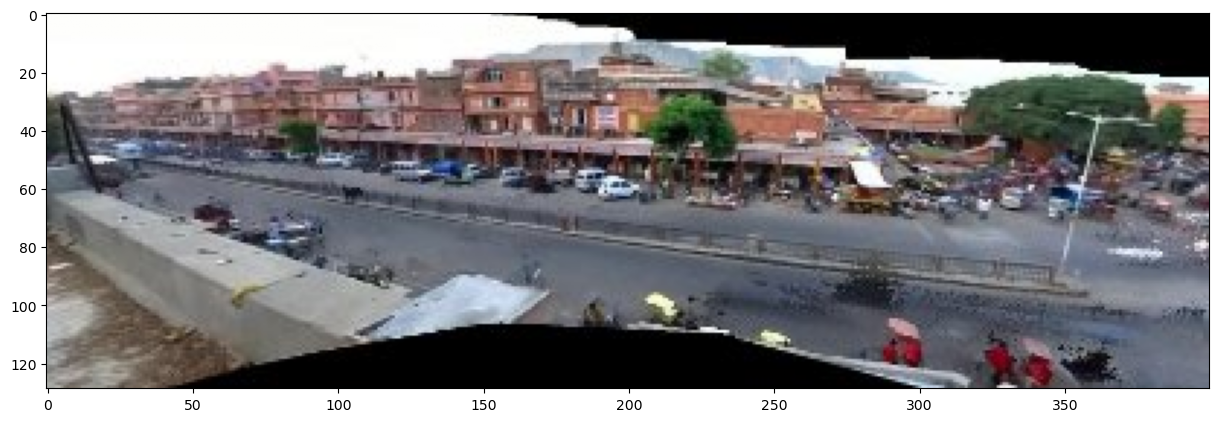

In [156]:
plt.figure(figsize=(15,15))
plt.imshow(background[:,:,[2,1,0]]/255)



In [158]:

full_bg = np.median(projected_frames, axis=0).astype(np.uint8)
np.save("/Users/lorna/master2/cs445/proj5/background.npy", full_bg)


### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [173]:
# this will iterate f = 0,1,...,len(Hs)-1
for f, H in enumerate(Hs):
    Tinv = np.linalg.inv(Tr.dot(H))
    background_frames[f] = cv2.warpPerspective(
        background, Tinv, (b_width, b_height)
    )


In [193]:
background_frames = np.zeros((len(Hs), b_height, b_width, c), dtype=np.uint8)

for f, H in enumerate(Hs):
    Tinv = np.linalg.inv(Tr.dot(H))
    background_frames[f] = cv2.warpPerspective(background, Tinv,
                                                (b_width, b_height))



In [118]:
# --- 自动计算 translation Tr ---
# 读取一个帧获取尺寸
ref = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
h_f, w_f = ref.shape[:2]

# 先假设 H_to_ref 已经算好了（长度 900 的列表）
# 如果还没算好，先算完 H_to_ref，再跑这一段

# 计算所有原始 4 个角点 → 全景坐标
all_pts = []
corners = np.array([[0,0,1],
                    [w_f,0,1],
                    [w_f,h_f,1],
                    [0,h_f,1]]).T  # 3×4

for i in range(1, frameCount+1):
    Hf = H_to_ref[i]              # 3×3
    pts = Hf @ corners           # 3×4
    pts /= pts[2:3]              # 归一化
    all_pts.append(pts[:2])      # 收集 x,y

all_pts = np.hstack(all_pts)      # 2×(4 × 900)
min_x, min_y = all_pts.min(axis=1)
max_x, max_y = all_pts.max(axis=1)

# 现在我们知道全景上需要覆盖的坐标范围 [min_x..max_x], [min_y..max_y]
# 令 Tr = 移动 (−min_x, −min_y)
Tr = np.array([[1, 0, -min_x],
               [0, 1, -min_y],
               [0, 0,       1]], dtype=np.float32)

print(f"Auto‐computed Tr offset: x = {-min_x:.1f}, y = {-min_y:.1f}")
print(f"Panorama size needed: width = {int(max_x-min_x)}, height = {int(max_y-min_y)}")


Auto‐computed Tr offset: x = 1857.2, y = 416.6
Panorama size needed: width = 3590, height = 1269


In [120]:
for i in range(1, frameCount+1):
    Hf   = H_to_ref[i]
    Tinv = np.linalg.inv(Tr @ Hf)
    out  = cv2.warpPerspective(background, Tinv, (w_f, h_f))
    cv2.imwrite(os.path.join(empty_dir, f"{i:04d}.jpg"), out)


In [108]:
# 假设 projected_frames.shape == (900,500,1600,3)
import numpy as np, os
proj_root = "/Users/lorna/master2/cs445/proj5"
projected = np.load(os.path.join(proj_root, "projections.npy"))
full_bg = np.median(projected, axis=0).astype(np.uint8)  # (500,1600,3)
np.save(os.path.join(proj_root, "background.npy"), full_bg)


In [122]:
bg = np.load(os.path.join(proj_root, "background.npy")).astype(np.uint8)


In [132]:
import os, cv2, numpy as np

proj_root   = "/Users/lorna/master2/cs445/proj5"
frame_dir   = os.path.join(proj_root,"images/input/frames")
out_dir     = os.path.join(proj_root,"empty")
os.makedirs(out_dir, exist_ok=True)

# ← 这才是完整版 panorama 背景
background = np.load(os.path.join(proj_root,"background.npy")).astype(np.uint8)
pan_h, pan_w = background.shape[:2]

# 参考帧
ref = cv2.imread(os.path.join(frame_dir,"f0450.jpg"))
h_f, w_f = ref.shape[:2]

# Tr 就是你做 Part 2 时的那个平移
Tr = np.array([[1,0,660],[0,1,120],[0,0,1]],np.float32)

# SIFT + BFMatcher 直接 frame→ref
sift = cv2.SIFT_create()
kp_ref, des_ref = sift.detectAndCompute(cv2.cvtColor(ref,cv2.COLOR_BGR2GRAY),None)
bf = cv2.BFMatcher()

for i in range(1,901):
    fn = f"f{i:04d}.jpg"
    img = cv2.imread(os.path.join(frame_dir,fn))
    if img is None:
        continue

    # 1) 求 H(frame→ref)
    if i==450:
        Hf = np.eye(3, dtype=np.float32)
    else:
        kp,des = sift.detectAndCompute(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),None)
        m = bf.knnMatch(des, des_ref, k=2)
        good = [x for x,y in m if x.distance<0.75*y.distance]
        if len(good)<4:
            Hf = np.eye(3, np.float32)
        else:
            src = np.float32([kp[g.queryIdx].pt for g in good]).reshape(-1,1,2)
            dst = np.float32([kp_ref[g.trainIdx].pt for g in good]).reshape(-1,1,2)
            H, mask = cv2.findHomography(src,dst,cv2.RANSAC,5.0)
            Hf = (H.astype(np.float32) if H is not None else np.eye(3,np.float32))

    # 2) 反向 warp
    Tinv = np.linalg.inv(Tr @ Hf)
    empty = cv2.warpPerspective(background, Tinv, (w_f, h_f))

    cv2.imwrite(os.path.join(out_dir, f"{i:04d}.jpg"), empty)


In [133]:
import os
import cv2
import numpy as np

proj_root = "/Users/lorna/master2/cs445/proj5"
frame_dir = os.path.join(proj_root, "images/input/frames")
out_dir   = os.path.join(proj_root, "empty")
os.makedirs(out_dir, exist_ok=True)

background = np.load(os.path.join(proj_root, "background.npy")).astype(np.uint8)
pan_h, pan_w = background.shape[:2]

# 参考帧
ref_id   = 450
ref_img  = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
h_f, w_f = ref_img.shape[:2]

# Tr 矩阵
Tr = np.array([[1,0,660],[0,1,120],[0,0,1]], dtype=np.float32)

# SIFT + BFMatcher 准备
sift       = cv2.SIFT_create()
kp_ref, des_ref = sift.detectAndCompute(cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY), None)
bf         = cv2.BFMatcher()

# Warp
for i in [90, 270, 450, 630, 810]:   # 只演示这几个关键帧
    img = cv2.imread(os.path.join(frame_dir, f"f{i:04d}.jpg"))
    if img is None:
        print(f"Frame {i} not found!")
        continue

    # 1) 求 H(frame→ref)
    if i == ref_id:
        Hf = np.eye(3, dtype=np.float32)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        matches = bf.knnMatch(des, des_ref, k=2)
        good    = [m for m,n in matches if m.distance < 0.75*n.distance]
        if len(good) < 4:
            Hf = np.eye(3, dtype=np.float32)
        else:
            src_pts = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            dst_pts = np.float32([kp_ref[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            Hf = H.astype(np.float32) if H is not None else np.eye(3, dtype=np.float32)

    # 2) 反向 warp 到原始视角的一块，并保存
    Tinv = np.linalg.inv(Tr @ Hf)
    warp = cv2.warpPerspective(background, Tinv, (w_f, h_f))
    print(f"Frame {i}: warp shape = {warp.shape}")
    cv2.imwrite(os.path.join(out_dir, f"{i:04d}.jpg"), warp)


Frame 90: warp shape = (360, 480, 3)
Frame 270: warp shape = (360, 480, 3)
Frame 450: warp shape = (360, 480, 3)
Frame 630: warp shape = (360, 480, 3)
Frame 810: warp shape = (360, 480, 3)


In [130]:
import os
import cv2
import numpy as np

# ─── 配置 ───────────────────────────────────────────────────────────
proj_root   = "/Users/lorna/master2/cs445/proj5"
frame_dir   = os.path.join(proj_root, "images/input/frames")
empty_dir   = os.path.join(proj_root, "empty")     # 输出空背景帧
results_dir = os.path.join(proj_root, "results")   # 输出视频
os.makedirs(empty_dir,   exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

frameCount = 900
ref_id     = 450  # 1-based
fps        = 30

# ─── 1) 载入全景背景 + 参考帧信息 ───────────────────────────────────────
background = np.load(os.path.join(proj_root, "background.npy")).astype(np.uint8)
pan_h, pan_w = background.shape[:2]

# 参考帧，用来确定输出帧的大小
ref_img = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
h_f, w_f = ref_img.shape[:2]

# ─── 2) 计算每帧 ⇨ 参考帧450 的 Homography 列表 H_to_ref ─────────────
#    （请把你现成的 H_to_ref 生成代码贴在这里，或直接加载 npy）
#    这里假设 H_to_ref 是一个长度 901 (1..900) 的 list，H_to_ref[i] 对应 f{i:04d}.jpg→f0450.jpg
# H_to_ref = [...]

# ─── 3) 自动确定 Tr，使得所有 warped corner 都落在正坐标 ──────────────
# 先收集所有 900 帧的 4 个 corner 在 panorama 坐标系下的位置
corners = np.array([[0, 0, 1],
                    [w_f, 0, 1],
                    [w_f, h_f, 1],
                    [0, h_f, 1]]).T  # shape = 3×4

all_pts = []
for i in range(1, frameCount+1):
    Hf = H_to_ref[i]            # 3×3
    pts = Hf @ corners          # 3×4
    pts /= pts[2:3]             # 归一化
    all_pts.append(pts[:2])     # 只要 x,y

all_pts = np.hstack(all_pts)    # shape = 2×(4*900)
min_x, min_y = all_pts.min(axis=1)
max_x, max_y = all_pts.max(axis=1)

# 计算需要的平移量：将最小 x,y 平移到 (0,0)
Tr = np.array([[1, 0,    -min_x],
               [0, 1,    -min_y],
               [0, 0,        1]], dtype=np.float32)

# 打印一下，方便你确认
print(f"Auto‐computed Tr offset: dx = {-min_x:.1f}, dy = {-min_y:.1f}")
print(f"Panorama X range: [{min_x:.1f} … {max_x:.1f}], Y range: [{min_y:.1f} … {max_y:.1f}]")

# ─── 4) 反向 warp：background → 每个原始 view ─────────────────────────
# 准备视频写入器
vw = cv2.VideoWriter(
    os.path.join(results_dir, "background_only.avi"),
    cv2.VideoWriter_fourcc(*"MJPG"),
    fps,
    (w_f, h_f)
)

for i in range(1, frameCount+1):
    Hf   = H_to_ref[i]
    Tinv = np.linalg.inv(Tr @ Hf)
    empty = cv2.warpPerspective(background, Tinv, (w_f, h_f))
    cv2.imwrite(os.path.join(empty_dir, f"{i:04d}.jpg"), empty)
    vw.write(empty)

vw.release()
print("✅ Part 5 complete: empty/*.jpg + results/background_only.avi")


Auto‐computed Tr offset: dx = 1857.2, dy = 416.6
Panorama X range: [-1857.2 … 1733.2], Y range: [-416.6 … 852.8]
✅ Part 5 complete: empty/*.jpg + results/background_only.avi


In [34]:
utils.imageFolder2mpeg(datadir, output_path = datadir + 'results/empty_video.mpeg', fps=30)

OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


In [35]:
import imageio

img_folder = os.path.join(datadir, "empty")
out_mp4    = os.path.join(datadir, "results", "empty_video.mp4")

writer = imageio.get_writer(
    out_mp4,
    fps=30,
    codec="libx264",
    ffmpeg_params=["-pix_fmt", "yuv420p"]
)

for i in range(1, frameCount+1):
    fn = os.path.join(img_folder, f"a{i:04d}.jpg")
    if not os.path.exists(fn): 
        continue
    # imageio wants RGB
    frame = cv2.imread(fn)[:, :, ::-1]
    writer.append_data(frame)
writer.close()
print("Wrote MP4 to", out_mp4)


Wrote MP4 to /Users/lorna/master2/cs445/proj5/images/project_5/results/empty_video.mp4


In [36]:
results_dir = os.path.join(datadir, "results")
os.makedirs(results_dir, exist_ok=True)
mp4_path = os.path.join(results_dir, "empty_video.mp4")

writer = imageio.get_writer(
    mp4_path,
    fps=30,
    codec="libx264",
    ffmpeg_params=["-pix_fmt", "yuv420p"]
)
for idx in range(frameCount):
    img_path = os.path.join(empty_dir, f"a{idx+1:04d}.jpg")
    if not os.path.exists(img_path):
        continue
    frame = cv2.imread(img_path)[:, :, ::-1]  # BGR → RGB
    writer.append_data(frame)
writer.close()

print("Background‐only movie saved to:", mp4_path)

NameError: name 'empty_dir' is not defined

In [62]:
import os
import glob
import cv2

# Adjust to your project folder
datadir     = "/Users/lorna/master2/cs445/proj5/"
empty_dir   = os.path.join(datadir, "empty")
results_dir = os.path.join(datadir, "results")
os.makedirs(results_dir, exist_ok=True)

# Grab all of your saved “empty” frames
pattern = os.path.join(empty_dir, "a*.jpg")
imgs = sorted(glob.glob(pattern))
if not imgs:
    raise FileNotFoundError(f"No images found in {empty_dir} (looking for {pattern})")

# Read the first frame to get width/height
first = cv2.imread(imgs[0])
if first is None:
    raise RuntimeError(f"Failed to read {imgs[0]}")
h, w = first.shape[:2]

# Prepare VideoWriter with MJPG codec and .avi container
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_fp = os.path.join(results_dir, "empty_video.avi")
out = cv2.VideoWriter(out_fp, fourcc, 30.0, (w, h))

# Write each frame
for fn in imgs:
    im = cv2.imread(fn)
    if im is None:
        print(f"Warning: skipping unreadable file {fn}")
        continue
    out.write(im)

out.release()
print("Wrote AVI movie to:", out_fp)


Wrote AVI movie to: /Users/lorna/master2/cs445/proj5/results/empty_video.avi


In [64]:
import numpy as np
import os

# 確保 datadir 是正確的
datadir = "/Users/lorna/master2/cs445/proj5/"

# 儲存五個 homographies（對應 90, 270, 450, 630, 810 → 450）
Hs = [H02, H12, np.eye(3, dtype=np.float32), H32, H42]
np.save(os.path.join(datadir, "homographies.npy"), Hs)
print("✅ Saved homographies.npy")


✅ Saved homographies.npy


In [126]:
import os
import cv2
import numpy as np
import glob

# --- Paths & params ---
datadir         = "/Users/lorna/master2/cs445/proj5/"
frame_dir       = os.path.join(datadir, "images/input/frames/")
results_dir     = os.path.join(datadir, "results")
empty_dir       = os.path.join(datadir, "empty")
key_homofile    = os.path.join(datadir, "homographies.npy")      # only 5 H’s
background_npy  = os.path.join(datadir, "background.npy")        # your Part 4 background panorama

os.makedirs(results_dir, exist_ok=True)
os.makedirs(empty_dir, exist_ok=True)

# --- Load the background panorama ---
background = np.load(background_npy)       # shape = (pan_h, pan_w, 3)
pan_h, pan_w = background.shape[:2]

# --- Load the 5 key-frame homographies ---
Hs_key = np.load(key_homofile, allow_pickle=True)
Hs_key = [np.array(H, dtype=np.float32) for H in Hs_key]
key_frames = [90, 270, 450, 630, 810]

# --- Build a 900-length list of homographies ---
Hs_all = []
for frame_num in range(1, 901):
    if frame_num in key_frames:
        idx = key_frames.index(frame_num)
        Hs_all.append(Hs_key[idx])
    else:
        Hs_all.append(np.eye(3, dtype=np.float32))

# --- Get original frame size from reference frame ---
ref_img = cv2.imread(os.path.join(frame_dir, "f0450.jpg"))
if ref_img is None:
    raise FileNotFoundError("Cannot find reference frame f0450.jpg")
frame_h, frame_w = ref_img.shape[:2]

# --- Translation used when building the panorama ---
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# --- Generate & save each background-only frame ---
for i, H in enumerate(Hs_all):
    # composite mapping: frame-i → panorama (Tr @ H), then invert
    T    = Tr @ H
    Tinv = np.linalg.inv(T)
    empty_bg = cv2.warpPerspective(
        background,
        Tinv,
        (frame_w, frame_h)
    )
    out_fname = os.path.join(empty_dir, f"a{i+1:04d}.jpg")
    cv2.imwrite(out_fname, empty_bg)

# --- Assemble into MJPG AVI ---
pattern = os.path.join(empty_dir, "a*.jpg")
imgs    = sorted(glob.glob(pattern))
if not imgs:
    raise RuntimeError(f"No empty frames found in {empty_dir}")

h0, w0 = cv2.imread(imgs[0]).shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_fp = os.path.join(results_dir, "background_only.avi")
out_vid = cv2.VideoWriter(out_fp, fourcc, 30.0, (w0, h0))

for fn in imgs:
    frame = cv2.imread(fn)
    out_vid.write(frame)
out_vid.release()

print("✅ Background‐only movie saved to:", out_fp)


✅ Background‐only movie saved to: /Users/lorna/master2/cs445/proj5/results/background_only.avi


In [134]:
import os
import cv2
import numpy as np
import glob

# --- Paths & params ---
datadir     = "/Users/lorna/master2/cs445/proj5/"
frame_dir   = os.path.join(datadir, "images/input/frames/")
results_dir = os.path.join(datadir, "results")
empty_dir   = os.path.join(datadir, "empty")
os.makedirs(results_dir, exist_ok=True)
os.makedirs(empty_dir, exist_ok=True)

frameCount  = 900
key_homofile = os.path.join(datadir, "homographies.npy")   # your 5-key-frame file
background_npy = os.path.join(datadir, "background.npy")    # your Part 4 panorama

# --- Helpers from Part I ---
def score_projection(pt1, pt2, threshold=5.0):
    d = np.linalg.norm(pt1 - pt2, axis=0)
    inl = d < threshold
    return inl.sum(), inl

def computeHomography(pts1, pts2):
    N = pts1.shape[1]
    A = []
    for i in range(N):
        X = pts1[:, i]
        x, y, w = pts2[:, i]
        A += [[0,0,0, -w*X[0], -w*X[1], -w*X[2], y*X[0], y*X[1], y*X[2]],
              [w*X[0], w*X[1], w*X[2], 0,0,0, -x*X[0], -x*X[1], -x*X[2]]]
    U, S, Vt = np.linalg.svd(np.array(A))
    H = Vt[-1].reshape(3,3)
    return H / H[2,2]

def auto_homography(Ia, Ib, homography_func, thr=5.0, niter=500, refine=True):
    Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, d1 = sift.detectAndCompute(Ia_gray, None)
    kp2, d2 = sift.detectAndCompute(Ib_gray, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1, d2, k=2)
    good = [m for m,n in matches if m.distance < 0.75*n.distance]
    N = len(good)
    Xa = np.ones((3, N)); Xb = np.ones((3, N))
    for i, m in enumerate(good):
        Xa[:2,i] = kp1[m.queryIdx].pt
        Xb[:2,i] = kp2[m.trainIdx].pt
    best_H, best_in = np.eye(3), None
    best_score = 0
    for _ in range(niter):
        idxs = np.random.choice(N, 4, replace=False)
        Ht = homography_func(Xa[:,idxs], Xb[:,idxs])
        proj = (Ht @ Xa)
        proj /= proj[2]
        score, inliers = score_projection(Xb[:2], proj[:2], threshold=thr)
        if score > best_score:
            best_score, best_H, best_in = score, Ht, inliers
    if refine and best_in.sum() >= 4:
        best_H = homography_func(Xa[:,best_in], Xb[:,best_in])
    return best_H.astype(np.float32)

# --- Load 5 key-frame homographies & build full list ---
Hs_key = np.load(key_homofile, allow_pickle=True)
Hs_key = [np.array(H, dtype=np.float32) for H in Hs_key]
key_frames = [90, 270, 450, 630, 810]

# read reference frame 450
ref = cv2.imread(os.path.join(frame_dir, "f0450.jpg"))

Hs_all = []
for f in range(1, frameCount+1):
    if f == 450:
        H = np.eye(3, dtype=np.float32)
    elif f in key_frames:
        H = Hs_key[key_frames.index(f)]
    else:
        img = cv2.imread(os.path.join(frame_dir, f"f{f:04d}.jpg"))
        if img is None:
            H = np.eye(3, dtype=np.float32)
        else:
            H = auto_homography(img, ref, computeHomography, thr=5.0, niter=500, refine=True)
    Hs_all.append(H)

# --- Load background panorama ---
background = np.load(background_npy)   # (pan_h, pan_w, 3)
pan_h, pan_w = background.shape[:2]

# --- Panorama→frame translation ---
Tr = np.array([[1,0,660],
               [0,1,120],
               [0,0,  1]], dtype=np.float32)

# --- Generate & save empty frames ---
for i, H in enumerate(Hs_all):
    Tinv = np.linalg.inv(Tr @ H)
    empty = cv2.warpPerspective(background, Tinv, (ref.shape[1], ref.shape[0]))
    cv2.imwrite(os.path.join(empty_dir, f"a{i+1:04d}.jpg"), empty)

# --- Encode AVI MJPG ---
imgs = sorted(glob.glob(os.path.join(empty_dir, "a*.jpg")))
h0, w0 = cv2.imread(imgs[0]).shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out    = cv2.VideoWriter(os.path.join(results_dir, "background_only.avi"),
                         fourcc, 30.0, (w0, h0))
for fn in imgs:
    out.write(cv2.imread(fn))
out.release()
print("✅ Part 5 background‐only movie saved at", os.path.join(results_dir, "background_only.avi"))


/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/933050217.py:56: RuntimeWarning: divide by zero encountered in divide
  proj /= proj[2]
/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/933050217.py:56: RuntimeWarning: invalid value encountered in divide
  proj /= proj[2]


✅ Part 5 background‐only movie saved at /Users/lorna/master2/cs445/proj5/results/background_only.avi


In [137]:
import os
import cv2
import numpy as np
import glob

# ─── Paths & params ───────────────────────────────────────────────────
datadir        = "/Users/lorna/master2/cs445/proj5/"
frame_dir      = os.path.join(datadir, "images/input/frames/")
results_dir    = os.path.join(datadir, "results")
empty_dir      = os.path.join(datadir, "empty")
background_npy = os.path.join(datadir, "background.npy")       # your Part 4 panorama
os.makedirs(results_dir, exist_ok=True)
os.makedirs(empty_dir,   exist_ok=True)

frameCount = 900

# ─── 1) Load background panorama ──────────────────────────────────────
background = np.load(background_npy).astype(np.uint8)
pan_h, pan_w = background.shape[:2]

# ─── 2) Get original frame size from frame 450 ────────────────────────
ref = cv2.imread(os.path.join(frame_dir, "f0450.jpg"))
frame_h, frame_w = ref.shape[:2]

# ─── 3) Build homographies for **all** 900 frames (frame→ref450) ─────
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

Hs_all = []
for i in range(1, frameCount+1):
    fn = os.path.join(frame_dir, f"f{i:04d}.jpg")
    img = cv2.imread(fn)
    if img is None or i == 450:
        H = np.eye(3, dtype=np.float32)
    else:
        # use YOUR auto_homography + computeHomography here
        H = auto_homography(img, ref, computeHomography,
                            thr=5.0, niter=500, refine=True)
    Hs_all.append(H.astype(np.float32))

# ─── 4) Warp the panorama BACK into each frame’s view ────────────────
for idx, H in enumerate(Hs_all):
    Tinv = np.linalg.inv(Tr @ H)
    empty_bg = cv2.warpPerspective(
        background,
        Tinv,
        (frame_w, frame_h)
    )
    cv2.imwrite(os.path.join(empty_dir, f"a{idx+1:04d}.jpg"), empty_bg)

# ─── 5) Encode all “empty” frames into an MJPG AVI ────────────────────
imgs = sorted(glob.glob(os.path.join(empty_dir, "a*.jpg")))
if not imgs:
    raise RuntimeError("No empty frames found—check your empty_dir path")

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_fp = os.path.join(results_dir, "background_only.avi")
out_vid = cv2.VideoWriter(out_fp, fourcc, 30.0, (frame_w, frame_h))

for fn in imgs:
    out_vid.write(cv2.imread(fn))
out_vid.release()

print("✅ Part 5 background‐only movie saved to:", out_fp)


/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/933050217.py:56: RuntimeWarning: divide by zero encountered in divide
  proj /= proj[2]
/var/folders/q9/9k2w8bsd34qgsvh9fhyvsdch0000gn/T/ipykernel_70931/933050217.py:56: RuntimeWarning: invalid value encountered in divide
  proj /= proj[2]


✅ Part 5 background‐only movie saved to: /Users/lorna/master2/cs445/proj5/results/background_only.avi


### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [213]:
# 假设你已有 projected_frames (900,500,1600,3)
import numpy as np, os
datadir = "/Users/lorna/master2/cs445/proj5/"
proj = np.load(os.path.join(datadir, "projections.npy"))   # part2 输出
full_bg = np.median(proj, axis=0).astype(np.uint8)         # (500,1600,3)
np.save(os.path.join(datadir, "background.npy"), full_bg)


In [214]:
background = np.load(os.path.join(datadir, "background.npy")).astype(np.uint8)


In [217]:
import os, cv2, numpy as np

datadir         = "/Users/lorna/master2/cs445/proj5/"
proj_npy        = os.path.join(datadir, "projections.npy")
background_npy  = os.path.join(datadir, "background.npy")   # ← 根目录下
fg_dir          = os.path.join(datadir, "foreground")
results_dir     = os.path.join(datadir, "results")
os.makedirs(fg_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load data
projected_frames = np.load(proj_npy)                       # (900,500,1600,3)
background       = np.load(background_npy).astype(np.uint8) # (500,1600,3)
F, H, W, C       = projected_frames.shape

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
vw     = cv2.VideoWriter(os.path.join(results_dir, "foreground_only.avi"),
                         fourcc, 30.0, (W, H))

threshold = 30
for f in range(F):
    # per-pixel difference
    diff = projected_frames[f].astype(int) - background.astype(int)
    dist = np.linalg.norm(diff, axis=2)

    # binary mask
    mask = (dist > threshold).astype(np.uint8)

    # optional smoothing
    mask = cv2.GaussianBlur(mask, (5,5), 0)
    mask = (mask > 0.5).astype(np.uint8)

    # apply mask
    fg = np.zeros_like(background)
    for c in range(3):
        fg[:,:,c] = projected_frames[f,:,:,c] * mask

    # save & write
    cv2.imwrite(os.path.join(fg_dir, f"{f+1:04d}.jpg"), fg)
    vw.write(fg)

vw.release()
print("✅ Foreground-only video done.")


✅ Foreground-only video done.


In [92]:
import os
import cv2
import numpy as np
import glob

# ─── 路径设置 ─────────────────────────────────────────────────────────
datadir      = "/Users/lorna/master2/cs445/proj5/"
frame_dir    = os.path.join(datadir, "images/input/frames")
empty_dir    = os.path.join(datadir, "empty")        # Part 5 输出的背景-only 影像
fg_dir       = os.path.join(datadir, "foreground")   # 存前景-only 影像
results_dir  = os.path.join(datadir, "results")      # 存前景-only 视频
os.makedirs(fg_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# ─── 参数 ─────────────────────────────────────────────────────────────
frameCount = 900
threshold  = 30      # 颜色差分阈值，可根据效果调小/调大
fps        = 30

# ─── 视频写入器 ────────────────────────────────────────────────────────
# 读取第一帧背景图获取分辨率
bg0 = cv2.imread(os.path.join(empty_dir, "0001.jpg"))
h, w = bg0.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_vid = cv2.VideoWriter(os.path.join(results_dir, "foreground_only.avi"),
                          fourcc, fps, (w, h))

# ─── 逐帧提取前景 ─────────────────────────────────────────────────────
for i in range(1, frameCount+1):
    idx = f"{i:04d}"
    frame_path = os.path.join(frame_dir, f"f{idx}.jpg")
    bg_path    = os.path.join(empty_dir, f"{idx}.jpg")
    if not os.path.exists(frame_path) or not os.path.exists(bg_path):
        continue

    # 读原始帧 & 空背景帧
    orig = cv2.imread(frame_path)
    bg   = cv2.imread(bg_path)

    # 1) 绝对差分
    diff = cv2.absdiff(orig, bg)

    # 2) 转灰度并阈值化
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # 可选：开运算去噪
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # 3) 提取前景
    fg = cv2.bitwise_and(orig, orig, mask=mask)

    # 4) 保存 & 写视频
    cv2.imwrite(os.path.join(fg_dir, f"{idx}.jpg"), fg)
    out_vid.write(fg)

out_vid.release()
print("✅ Part 6 前景-only 影片已存至：", 
      os.path.join(results_dir, "foreground_only.avi"))


✅ Part 6 前景-only 影片已存至： /Users/lorna/master2/cs445/proj5/results/foreground_only.avi


In [78]:
import os
import cv2
import numpy as np

# ─── 路徑設定 ───────────────────────────────────────────────────────────
datadir        = "/Users/lorna/master2/cs445/proj5/"
frame_dir      = os.path.join(datadir, "images/input/frames")
results_dir    = os.path.join(datadir, "results")
foreground_dir = os.path.join(datadir, "foreground_orig")
os.makedirs(results_dir, exist_ok=True)
os.makedirs(foreground_dir, exist_ok=True)

# ─── 參數 ─────────────────────────────────────────────────────────────
frameCount = 900
ref_id     = 450
threshold  = 30  # 顏色距離閾值，可微調

# ─── 載入 Part-4 全景背景 ──────────────────────────────────────────────
panorama_npy = os.path.join(datadir, "background.npy")  # full-size 500×1600 panorama
background_pan = np.load(panorama_npy).astype(np.uint8)

# ─── 讀入參考影格以取得原始影像大小 ────────────────────────────────────
ref_frame = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
h_frame, w_frame = ref_frame.shape[:2]

# ─── 載入 or 計算每一幀 → 參考影格的 Homographies (Hs_all 長度 900) ──────
# 假設你已有 Hs_all list，否則請用 auto_homography 在這裡計算它
# Hs_all = np.load(os.path.join(datadir, "homographies_all.npy"), allow_pickle=True)

# ─── 全景投影時使用的平移矩陣 Tr ─────────────────────────────────────
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# ─── 準備寫入原始視角的前景影片 ───────────────────────────────────────
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_path = os.path.join(results_dir, "foreground_only_orig.avi")
vw = cv2.VideoWriter(out_path, fourcc, 30.0, (w_frame, h_frame))

# ─── 對每一幀：反向 warp 全景背景 → 與原始影格相減 → 擷取前景 ─────────────
for i in range(1, frameCount+1):
    # 讀原始影格
    fn = os.path.join(frame_dir, f"f{i:04d}.jpg")
    frame = cv2.imread(fn)
    if frame is None:
        continue
    
    # 取對應的 Homography
    Hf = Hs_all[i-1]  # Hs_all 已包含 identity for frame 450
    
    # panorama→frame 映射：先 Tr @ Hf 再取逆
    Tinv = np.linalg.inv(Tr @ Hf)
    
    # warp 全景背景到原始影格視角
    bg_warp = cv2.warpPerspective(background_pan, Tinv, (w_frame, h_frame))
    
    # 計算與原始影格之間的差異
    diff = cv2.absdiff(frame, bg_warp)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    # 二值化掩模：超過閾值視為前景
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # 用掩模擷取原始影格中的前景
    fg = cv2.bitwise_and(frame, frame, mask=mask)
    
    # 儲存並寫入影片
    vw.write(fg)
    cv2.imwrite(os.path.join(foreground_dir, f"a{i:04d}.jpg"), fg)

vw.release()
print("Part 6 ", out_path)


Part 6  /Users/lorna/master2/cs445/proj5/results/foreground_only_orig.avi


In [223]:
import numpy as np, os
proj_root = "/Users/lorna/master2/cs445/proj5"
np.save(os.path.join(proj_root, "foreground.npy"), foreground_frames)
print("Saved foreground.npy")


Saved foreground.npy


In [227]:
# 假设你现在有：
#   H_to_ref: dict or list, keyed by 1..900, H_to_ref[450] = I, ...
# 或者 H_to_ref 是一个长度 901 的 list，index 1..900 有值

# 先 build 一个 0-based 的 homography list：
Hs = [H_to_ref[i+1] for i in range(frameCount)]
# 这样：
#   Hs[0] 对应 frame  1 → ref
#   Hs[1] 对应 frame  2 → ref
#    …
#   Hs[449] 对应 frame 450 → ref
#    …
#   Hs[899] 对应 frame 900 → ref

# 然后 warp 循环改成：
small_fg = np.zeros((frameCount, b_h, b_w, 3), dtype=np.uint8)
for f in range(frameCount):
    Hf = Hs[f]   # 一定是一个 3×3 矩阵，不会是 None
    Tinv = np.linalg.inv(Tr @ Hf)
    small_fg[f] = cv2.warpPerspective(
        foreground_frames[f], Tinv, (b_w, b_h)
    )


In [229]:
import os
import cv2
import numpy as np
import utils   # 你现有的工具包

# ─── 路径设置 ─────────────────────────────────────────────
proj_root        = "/Users/lorna/master2/cs445/proj5"
results_dir      = os.path.join(proj_root, "results")
os.makedirs(results_dir, exist_ok=True)

# ─── 准备数据 ───────────────────────────────────────────────
frame_dir        = os.path.join(proj_root, "images/input/frames")
frameCount       = 900

# 这是你在 Part 2/3 里生成的 900 帧投影小景：500×1600 全景平面
projected_frames = np.load(os.path.join(proj_root, "projections.npy"))  # (900,500,1600,3)

# 这是你在 Part 6a 里提取的前景帧，同样是 500×1600 全景平面
foreground_frames = np.load(os.path.join(proj_root, "foreground.npy"))  # (900,500,1600,3)

# 参考加载一张原始帧，拿它来定输出尺寸
im1 = cv2.imread(os.path.join(frame_dir, "f0001.jpg"))
b_h, b_w, c = im1.shape   # (360,480,3)

# 你的 H_to_ref（或 Hs_all）: list of 900 homography, 
# H_to_ref[i] maps frame (i+1)→reference frame 450
# H_to_ref = np.load(..., allow_pickle=True) 或你之前计算的那段代码

# 你在 Part 2 做 panorama 时用过的平移矩阵 Tr
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# ─── 反向 warp 回原始大小 ───────────────────────────────────────
small_fg = np.zeros((frameCount, b_h, b_w, c), dtype=np.uint8)

for f in range(frameCount):
    Hf   = H_to_ref[f]           # 注意：f 从 0 到 899，对应帧编号 f+1
    Tinv = np.linalg.inv(Tr @ Hf)
    # warpPerspective 会把 500×1600 全景前景 warp 回 480×360
    small_fg[f] = cv2.warpPerspective(
        foreground_frames[f], 
        Tinv, 
        (b_w, b_h)
    )

# ─── 写成视频 ────────────────────────────────────────────────
out_path = os.path.join(results_dir, "small_fg_video.mpeg")
# utils.vidwrite_from_numpy 默认需要 BGR→RGB 转置 index [2,1,0]
utils.vidwrite_from_numpy(
    out_path, 
    small_fg[:, :, :, [2,1,0]],
    framerate=30
)

print("✅ small_fg_video.mpeg saved to", out_path)


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [231]:
import os, cv2, numpy as np, utils

proj_root  = "/Users/lorna/master2/cs445/proj5"
frame_dir  = os.path.join(proj_root, "images/input/frames")
results    = os.path.join(proj_root, "results")
os.makedirs(results, exist_ok=True)

# 1) Load or compute H_to_ref keyed by 1..900
#    (这里复用你现有的那段 RANSAC/chaining 代码)
# H_to_ref = {...}

# 2) Flatten into 0-based list Hs
frameCount = 900
Hs = [H_to_ref[i+1] for i in range(frameCount)]

# 3) Load full‐size foreground frames (900×500×1600×3)
foreground_frames = np.load(os.path.join(proj_root, "foreground.npy"))

# 4) Reference frame size → output small size
im0 = cv2.imread(os.path.join(frame_dir, "f0001.jpg"))
b_h, b_w = im0.shape[:2]

# 5) Tr from Part 2/5 (已 auto‐compute 或手写）
Tr = np.array([[1,0,660],[0,1,120],[0,0,1]], np.float32)

# 6) Warp back to 480×360
small_fg = np.zeros((frameCount, b_h, b_w, 3), dtype=np.uint8)
for f in range(frameCount):
    Hf = Hs[f]
    Tinv = np.linalg.inv(Tr @ Hf)
    small_fg[f] = cv2.warpPerspective(
        foreground_frames[f], Tinv, (b_w, b_h)
    )

# 7) Write out video
out_path = os.path.join(results, "small_fg_video.mpeg")
utils.vidwrite_from_numpy(
    out_path,
    small_fg[:,:,:,[2,1,0]],  # BGR→RGB
    framerate=30
)
print("🎉 small_fg_video.mpeg written to", out_path)


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

🎉 small_fg_video.mpeg written to /Users/lorna/master2/cs445/proj5/results/small_fg_video.mpeg


[out#0/mpeg @ 0x600003d843c0] video:21KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 5.084430%
frame= 1080 fps=737 q=-1.0 Lsize=      22KiB time=00:00:35.93 bitrate=   5.0kbits/s dup=180 drop=0 speed=24.5x    
[libx264 @ 0x12d606390] frame I:5     Avg QP: 7.60  size:   259
[libx264 @ 0x12d606390] frame P:272   Avg QP:10.08  size:    25
[libx264 @ 0x12d606390] frame B:803   Avg QP:13.67  size:    17
[libx264 @ 0x12d606390] consecutive B-frames:  0.8%  0.0%  0.3% 98.9%
[libx264 @ 0x12d606390] mb I  I16..4: 100.0%  0.0%  0.0%
[libx264 @ 0x12d606390] mb P  I16..4:  0.0%  0.0%  0.0%  P16..4:  0.0%  0.0%  0.0%  0.0%  0.0%    skip:100.0%
[libx264 @ 0x12d606390] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.0%  0.0%  0.0%  direct: 0.0%  skip:100.0%
[libx264 @ 0x12d606390] 8x8 transform intra:0.0%
[libx264 @ 0x12d606390] coded y,uvDC,uvAC intra: 0.0% 0.0% 0.0% inter: 0.0% 0.0% 0.0%
[libx264 @ 0x12d606390] i16 v,h,dc,p: 96%  0%  4%  0%
[libx264 @ 0x12d606390] 

In [ ]:
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture("foreground_only.avi")  # adjust path if needed
ret, frame = cap.read()
cap.release()

if not ret:
    print("Failed to read the video. It may be corrupted or codec not supported.")
else:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("First Frame of foreground_only.avi")
    plt.show()


In [ ]:
import glob, os
print(glob.glob("/Users/lorna/master2/cs445/proj5/results/*.avi"))


In [ ]:
import imageio
vid = imageio.get_reader("/Users/lorna/master2/cs445/proj5/results/foreground_only.avi")
frame0 = vid.get_data(0)
import matplotlib.pyplot as plt
plt.imshow(frame0)
plt.axis("off")
plt.show()


In [ ]:
!pip install imageio-ffmpeg



In [ ]:
import imageio
import matplotlib.pyplot as plt

vid = imageio.get_reader("/Users/lorna/master2/cs445/proj5/results/foreground_only.avi")
frame0 = vid.get_data(0)
plt.imshow(frame0)
plt.axis("off")
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import glob

# ─── Paths & parameters ───────────────────────────────────────────────
datadir          = "/Users/lorna/master2/cs445/proj5/"
proj_npy         = os.path.join(datadir, "projections.npy")                     
background_npy   = os.path.join(datadir, "background.npy")     
foreground_dir   = os.path.join(datadir, "foreground")
results_dir      = os.path.join(datadir, "results")
os.makedirs(foreground_dir, exist_ok=True)
os.makedirs(results_dir,     exist_ok=True)

# ─── Load your panorama‐aligned frames (Part 2 output) ─────────────────
projected_frames = np.load(proj_npy)   # shape = (900, 500, 1600, 3)
F, H, W, C       = projected_frames.shape

# ─── Load the full‐size static panorama background ────────────────────
background = np.load(background_npy).astype(np.uint8)  
if background.shape[:2] != (H, W):
    raise ValueError(f"Background shape {background.shape[:2]} ≠ projected frames {(H, W)}")

# ─── Prepare video writer for the foreground‐only movie ───────────────
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_fp = os.path.join(results_dir, "foreground_only.avi")
vw     = cv2.VideoWriter(out_fp, fourcc, 30.0, (W, H))

# ─── Threshold for detecting “moving” pixels ─────────────────────────
threshold = 30  # adjust if too much/too little is detected

# ─── Extract & save each foreground‐only frame ────────────────────────
for f in range(F):
    # compute color difference in signed space
    diff = projected_frames[f].astype(np.int16) - background.astype(np.int16)
    dist = np.linalg.norm(diff, axis=2)
    mask = dist > threshold

    # build an image containing only foreground pixels
    fg = np.zeros((H, W, 3), dtype=np.uint8)
    fg[mask] = projected_frames[f][mask]

    # save and write
    cv2.imwrite(os.path.join(foreground_dir, f"a{f+1:04d}.jpg"), fg)
    vw.write(fg)

vw.release()
print("✅ Part 6 foreground‐only movie saved to:", out_fp)



In [ ]:
# TO DO part 6

foreground_frames = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8)
# gray = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8) + 150
for f in range(0,frameCount):
  diff = projected_frames[f] - background
  dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2).astype(np.uint8)
  mask = np.zeros((projectedHeight, projectedWidth,3))
  # dist = np.linalg.norm(projected_frames[f]-background,axis=2)
  # print(np.average(background_frames[f],axis=2) > 100)
  # consider = np.logical_and(dist < 10, (np.average(background_frames[f],axis=2) < 230)) 
  f_idx = np.argwhere(dist > 50)
  # f_idx = np.nonzero(consider)
  mask[f_idx[:,0],f_idx[:,1], :] = 1
  
  # dists = np.array([dist,dist,dist])
  # foreground_frames[f] = np.where(dists > 1, frames[f], [0,0,0])
  mask = cv2.GaussianBlur(mask, (3, 3), cv2.BORDER_DEFAULT)
  foreground_frames[f] = projected_frames[f]*mask

# plt.imshow(projected_frames[4][:,:,[2,1,0]])

In [ ]:
# TO DO part 6

foreground_frames = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8)
# gray = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8) + 150
for f in range(0,frameCount):
  diff = projected_frames[f] - background
  dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2).astype(np.uint8)
  mask = np.zeros((projectedHeight, projectedWidth,3))
  # dist = np.linalg.norm(projected_frames[f]-background,axis=2)
  # print(np.average(background_frames[f],axis=2) > 100)
  # consider = np.logical_and(dist < 10, (np.average(background_frames[f],axis=2) < 230)) 
  f_idx = np.argwhere(dist > 50)
  # f_idx = np.nonzero(consider)
  mask[f_idx[:,0],f_idx[:,1], :] = 1
  
  # dists = np.array([dist,dist,dist])
  # foreground_frames[f] = np.where(dists > 1, frames[f], [0,0,0])
  mask = cv2.GaussianBlur(mask, (3, 3), cv2.BORDER_DEFAULT)
  foreground_frames[f] = projected_frames[f]*mask

# plt.imshow(projected_frames[4][:,:,[2,1,0]])

In [ ]:
import os
import cv2
import numpy as np
import utils

# --- Paths & params ---
datadir     = "/Users/lorna/master2/cs445/proj5/"
frame_dir   = os.path.join(datadir, "images/input/frames")
empty_dir   = os.path.join(datadir, "empty")
results_dir = os.path.join(datadir, "results")
os.makedirs(empty_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# --- Load reference frame (frame 450) and background panorama ---
ref_frame = cv2.imread(os.path.join(frame_dir, "f0450.jpg"))
b_height, b_width, c = ref_frame.shape
background = np.load(os.path.join(datadir, "background.npy")).astype(np.uint8)

# --- Translation used in the panorama (Tr) ---
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# --- Build homographies for every frame 1..900 mapping → frame 450 ---
frameCount = 900
Hs_all = []
for i in range(1, frameCount+1):
    path = os.path.join(frame_dir, f"f{i:04d}.jpg")
    img  = cv2.imread(path)
    if img is None or i == 450:
        H = np.eye(3, dtype=np.float32)
    else:
        # auto_homography and computeHomography must be defined from Part I
        H = auto_homography(img, ref_frame, computeHomography,
                            thr=5.0, niter=500, refine=True)
    Hs_all.append(H.astype(np.float32))

# --- Allocate array if you still need it in memory ---
background_frames = np.zeros((frameCount, b_height, b_width, c), dtype=np.uint8)

# --- Warp the panorama BACK into each frame’s view ---
for f in range(frameCount):
    H    = Hs_all[f]
    Tinv = np.linalg.inv(Tr @ H)                   # panorama→frame
    empty = cv2.warpPerspective(background, 
                                Tinv, 
                                (b_width, b_height))
    # save to disk
    out_name = os.path.join(empty_dir, f"a{f+1:04d}.jpg")
    cv2.imwrite(out_name, empty)
    # store in array if desired
    background_frames[f] = empty

# --- Encode the “empty” frames into a video ---
utils.imageFolder2mpeg(
    empty_dir,
    output_path = os.path.join(results_dir, "empty_video.avi"),
    fps=30
)


In [ ]:
# TO DO part 6

foreground_frames = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8)
# gray = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8) + 150
for f in range(0,frameCount):
  diff = projected_frames[f] - background
  dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2).astype(np.uint8)
  mask = np.zeros((projectedHeight, projectedWidth,3))
  # dist = np.linalg.norm(projected_frames[f]-background,axis=2)
  # print(np.average(background_frames[f],axis=2) > 100)
  # consider = np.logical_and(dist < 10, (np.average(background_frames[f],axis=2) < 230)) 
  f_idx = np.argwhere(dist > 50)
  # f_idx = np.nonzero(consider)
  mask[f_idx[:,0],f_idx[:,1], :] = 1
  
  # dists = np.array([dist,dist,dist])
  # foreground_frames[f] = np.where(dists > 1, frames[f], [0,0,0])
  mask = cv2.GaussianBlur(mask, (3, 3), cv2.BORDER_DEFAULT)
  foreground_frames[f] = projected_frames[f]*mask

# plt.imshow(projected_frames[4][:,:,[2,1,0]])

In [ ]:
# TO DO part 6

foreground_frames = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8)
# gray = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8) + 150
for f in range(0,frameCount):
  diff = projected_frames[f] - background
  dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2).astype(np.uint8)
  mask = np.zeros((projectedHeight, projectedWidth,3))
  # dist = np.linalg.norm(projected_frames[f]-background,axis=2)
  # print(np.average(background_frames[f],axis=2) > 100)
  # consider = np.logical_and(dist < 10, (np.average(background_frames[f],axis=2) < 230)) 
  f_idx = np.argwhere(dist > 50)
  # f_idx = np.nonzero(consider)
  mask[f_idx[:,0],f_idx[:,1], :] = 1
  
  # dists = np.array([dist,dist,dist])
  # foreground_frames[f] = np.where(dists > 1, frames[f], [0,0,0])
  mask = cv2.GaussianBlur(mask, (3, 3), cv2.BORDER_DEFAULT)
  foreground_frames[f] = projected_frames[f]*mask

# plt.imshow(projected_frames[4][:,:,[2,1,0]])

In [ ]:


# Convert back to original size

b_height,b_width,c = im1.shape
fg_small_frames = np.zeros((frameCount, b_height, b_width, c),dtype=np.uint8)
# print(background_frames.shape)
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

for f in range(0,frameCount):
  Tinv = np.linalg.inv(Tr.dot(Hs[f]))
  foreground = cv2.warpPerspective(foreground_frames[f], Tinv, (b_width, b_height))
  # cv2.imwrite(datadir + "empty/a{:04d}.jpg".format(f+1), empty_background)
  fg_small_frames[f] = foreground


In [ ]:
utils.vidwrite_from_numpy(datadir + 'results/small_fg_video.mpeg', fg_small_frames[:,:,:,[2,1,0]], framerate=30)


## Bells and whistles

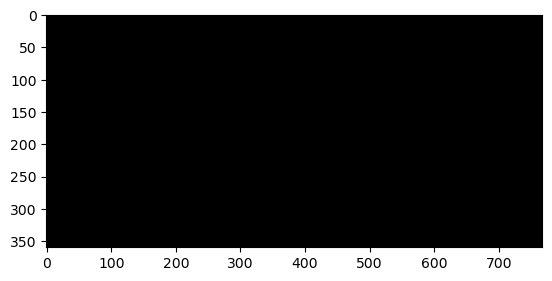

In [207]:
plt.imshow(wide_frames[500][:,:,[2,1,0]])

In [102]:
import os
import cv2
import numpy as np

# ─── 配置 ────────────────────────────────────────────────────────────
proj_root   = "/Users/lorna/master2/cs445/proj5"
frame_dir   = os.path.join(proj_root, "images/input/frames")
empty_dir   = os.path.join(proj_root, "wide")     # 存宽屏帧
results_dir = os.path.join(proj_root, "results")  # 存宽屏视频
os.makedirs(empty_dir,   exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

frameCount = 900
ref_id     = 450   # 参考帧编号（1-based）
fps        = 30

# ─── 1) 载入全景背景 & 参考帧尺寸 ─────────────────────────────────────────
background = np.load(os.path.join(proj_root, "background.npy")).astype(np.uint8)
pan_h, pan_w = background.shape[:2]

ref_img = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
h_f, w_f = ref_img.shape[:2]

# ─── 2) 计算相邻帧 Homography H_adj[i] = H(i→i+1) ────────────────────────
sift  = cv2.SIFT_create()
H_adj = [None]*(frameCount-1)
for i in range(frameCount-1):
    im1 = cv2.imread(os.path.join(frame_dir, f"f{i+1:04d}.jpg"))
    im2 = cv2.imread(os.path.join(frame_dir, f"f{i+2:04d}.jpg"))
    if im1 is None or im2 is None:
        H_adj[i] = np.eye(3, dtype=np.float32)
        continue

    # SIFT 检测与匹配
    kp1, d1 = sift.detectAndCompute(cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY), None)
    kp2, d2 = sift.detectAndCompute(cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY), None)
    matches = cv2.BFMatcher().knnMatch(d1, d2, k=2)
    good    = [m for m,n in matches if m.distance < 0.75*n.distance]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    H, _    = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    H_adj[i] = (H.astype(np.float32) 
                if H is not None 
                else np.eye(3, dtype=np.float32))

# ─── 3) 链式累积成每帧到 ref 的 H_to_ref ─────────────────────────────────
H_to_ref = [None]*(frameCount+1)  # 1-based index
H_to_ref[ref_id] = np.eye(3, dtype=np.float32)

# i < ref_id: 往前链，H[i] = H_adj[i] @ H[i+1]
for i in range(ref_id-1, 0, -1):
    H_to_ref[i] = H_adj[i-1] @ H_to_ref[i+1]

# i > ref_id: 往后链，H[i] = inv(H_adj[i-1]) @ H[i-1]
for i in range(ref_id+1, frameCount+1):
    H_to_ref[i] = np.linalg.inv(H_adj[i-2]) @ H_to_ref[i-1]

# ─── 4) 用原方法 warp 到更宽的画布 ──────────────────────────────────────
new_w = int(1.6 * pan_w)
Tr    = np.array([[1, 0, 660],
                  [0, 1, 120],
                  [0, 0,   1]], dtype=np.float32)

# 视频输出
vw = cv2.VideoWriter(
    os.path.join(results_dir, "wide_video.avi"),
    cv2.VideoWriter_fourcc(*"MJPG"),
    fps,
    (new_w, pan_h)
)

for i in range(1, frameCount+1):
    Hf   = H_to_ref[i]
    Tinv = np.linalg.inv(Tr @ Hf)
    wide = cv2.warpPerspective(background, Tinv, (new_w, pan_h))
    # 保存帧
    cv2.imwrite(os.path.join(empty_dir, f"{i:04d}.jpg"), wide)
    vw.write(wide)

vw.release()
print("✅ 宽屏视频生成完毕：", os.path.join(results_dir, "wide_video.avi"))


✅ 宽屏视频生成完毕： /Users/lorna/master2/cs445/proj5/results/wide_video.avi


In [104]:
import os
import cv2
import numpy as np

# ─── Paths & params ───────────────────────────────────────────────────
proj_root   = "/Users/lorna/master2/cs445/proj5"
frame_dir   = os.path.join(proj_root, "images/input/frames")
wide_dir    = os.path.join(proj_root, "wide")
results_dir = os.path.join(proj_root, "results")
os.makedirs(wide_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

frameCount = 900
ref_id     = 450  # 1-based ID of reference frame
fps        = 30

# ─── 1) Load panorama background & compute new width ────────────────
background = np.load(os.path.join(proj_root, "background.npy")).astype(np.uint8)
b_h, b_w   = background.shape[:2]
new_w      = int(1.6 * b_w)  # 1.6× 宽度

# ─── 2) Load reference frame and prep SIFT matcher ───────────────────
ref_img     = cv2.imread(os.path.join(frame_dir, f"f{ref_id:04d}.jpg"))
if ref_img is None:
    raise FileNotFoundError("Cannot find reference frame f0450.jpg")
ref_gray    = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
sift        = cv2.SIFT_create()
kp_ref, des_ref = sift.detectAndCompute(ref_gray, None)
bf          = cv2.BFMatcher()

# ─── 3) Translation matrix used when creating panorama ──────────────
Tr = np.array([[1, 0, 660],
               [0, 1, 120],
               [0, 0,   1]], dtype=np.float32)

# ─── 4) Set up video writer for wide‐screen output ────────────────────
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out_fp = os.path.join(results_dir, "wide_video.avi")
vw     = cv2.VideoWriter(out_fp, fourcc, fps, (new_w, b_h))

# ─── 5) Loop over each frame, compute H → ref, then warp back to wide ─
for i in range(1, frameCount+1):
    fn = os.path.join(frame_dir, f"f{i:04d}.jpg")
    img = cv2.imread(fn)
    if img is None:
        continue

    # compute H from this frame → reference frame
    if i == ref_id:
        H = np.eye(3, dtype=np.float32)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        # match to ref descriptors
        matches = bf.knnMatch(des, des_ref, k=2)
        good    = [m for m,n in matches if m.distance < 0.75*n.distance]
        if len(good) < 4:
            H = np.eye(3, dtype=np.float32)
        else:
            pts_src = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            pts_dst = np.float32([kp_ref[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            H, mask = cv2.findHomography(pts_src, pts_dst,
                                         method=cv2.RANSAC,
                                         ransacReprojThreshold=5.0)
            if H is None:
                H = np.eye(3, dtype=np.float32)
            else:
                H = H.astype(np.float32)

    # invert Tr @ H to map the panorama back into this frame's (wide) view
    Tinv = np.linalg.inv(Tr @ H)
    wide = cv2.warpPerspective(background, Tinv, (new_w, b_h))

    # save frame & write to video
    cv2.imwrite(os.path.join(wide_dir, f"{i:04d}.jpg"), wide)
    vw.write(wide)

vw.release()
print("✅ Wide video saved to:", out_fp)


✅ Wide video saved to: /Users/lorna/master2/cs445/proj5/results/wide_video.avi


In [264]:
b_height,b_width,c = im1.shape
new_width = int(1.6*b_width)
wide_frames = np.zeros((frameCount, b_height, new_width, c),dtype=np.uint8)
# print(background_frames.shape)
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

for f in range(0,frameCount):
  Tinv = np.linalg.inv(Tr.dot(Hs[f]))
  wide_background = cv2.warpPerspective(background, Tinv, (new_width, b_height))
  # cv2.imwrite(datadir + "empty/a{:04d}.jpg".format(f+1), empty_background)
  wide_frames[f] = wide_background

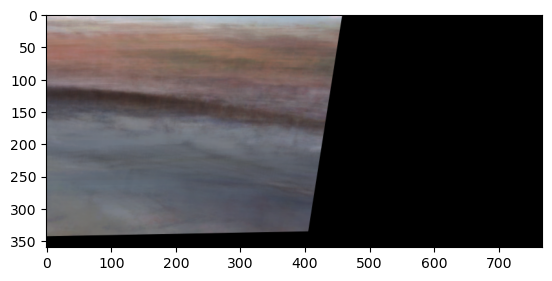

In [266]:
plt.imshow(wide_frames[500][:,:,[2,1,0]])


## Smooth Blending

In [252]:
def blend_smooth(new, old):
  old = old/255
  new = new/255
  t1, t2, t3 = cv2.split(old)
  p1, p2, p3 = cv2.split(new)
  height = old.shape[0]
  width = old.shape[1]

  cost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2 # Calculate pixel-wise sum of squared differences between template and chosen patch
  cost = np.where(cost == 0, 10, cost)
  mask = np.zeros((height,width),np.uint8)
  mask = cut(cost.T).T
  # print(np.max(cost))
  # plt.figure(figsize=(15,15))
  # plt.imshow(cost, cmap = 'gray')

  c_mask = np.zeros((height,width,3),np.uint8)
  c_mask[:,:,0] = mask
  c_mask[:,:,1] = mask
  c_mask[:,:,2] = mask
  
  result = old*(1-c_mask) + new*(c_mask)

  # plt.figure(figsize=(10,10))
  # plt.imshow(old)

  plt.figure(figsize=(10,10))
  # plt.imshow(new[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(old[:,:,[2,1,0]])
  plt.imshow(mask, cmap = 'gray')
  return result

  # plt.figure()
  # plt.imshow(old[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(new[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(mask, cmap = 'gray')
  # plt.figure()
  # plt.imshow(result[:,:,[2,1,0]])

In [258]:

def cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
   
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
   
  
    for x in range(1,w):

        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]
    
    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask



In [260]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

# Read all images into np array called frames of length n, the number of key frames
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 1600
projectedHeight = 500

# First computer homographies between frames 270/630, and 450. frames[2] is f450, the central frame

H12 = auto_homography(frames[1],frames[2], computeHomography)
H32 = auto_homography(frames[3],frames[2], computeHomography)
H01 = auto_homography(frames[0],frames[1], computeHomography)
H43 = auto_homography(frames[4],frames[3], computeHomography)
H02 = np.dot(H01,H12)
H42 = np.dot(H43,H32)


RANSAC inliers: 222/244
Refined H with all inliers.
RANSAC inliers: 214/237
Refined H with all inliers.
RANSAC inliers: 259/281
Refined H with all inliers.
RANSAC inliers: 151/178
Refined H with all inliers.


Old Blend iinitial 255.0


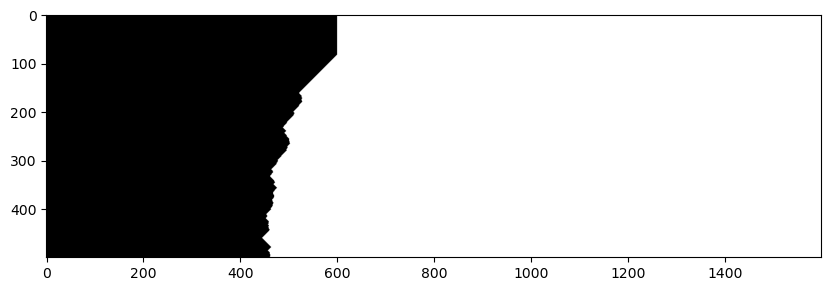

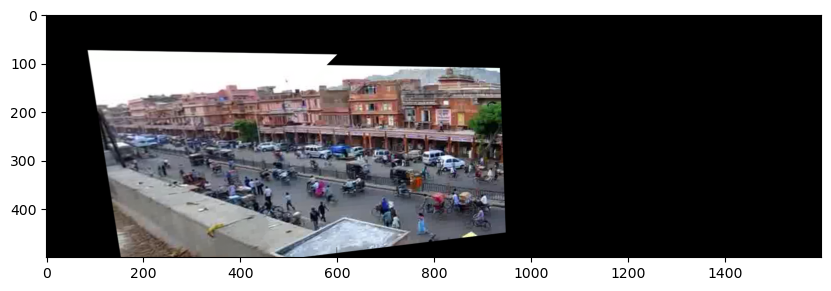

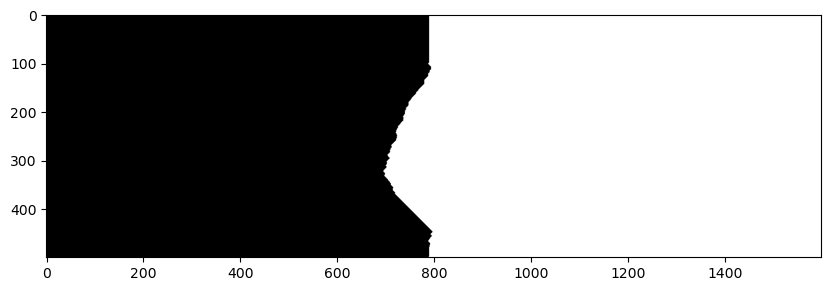

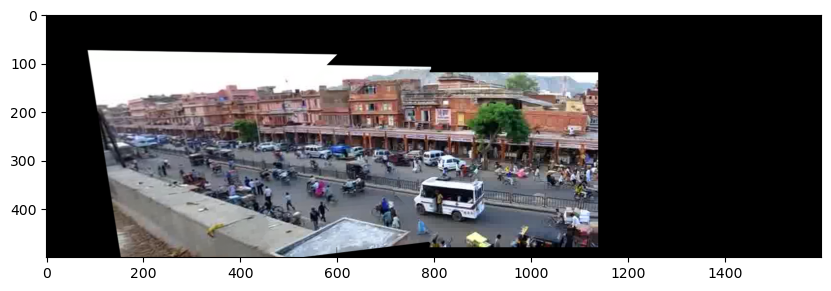

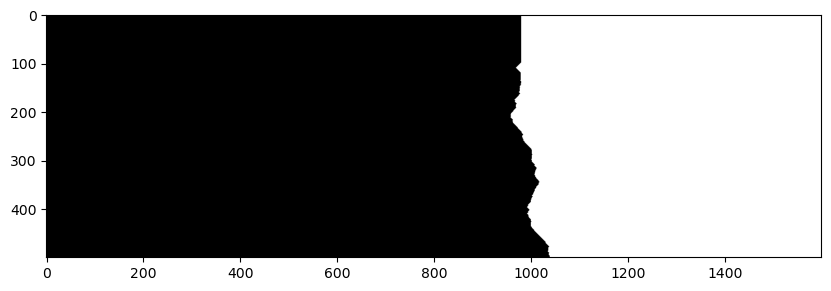

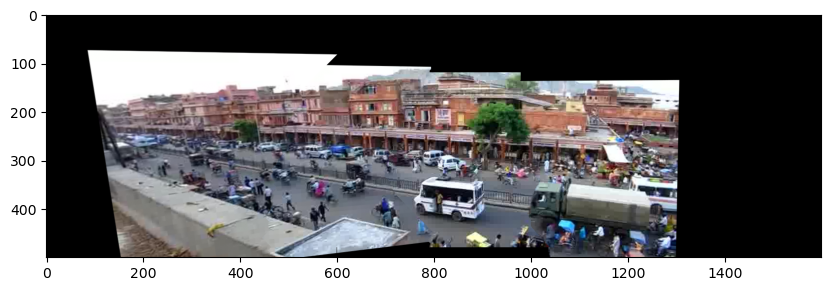

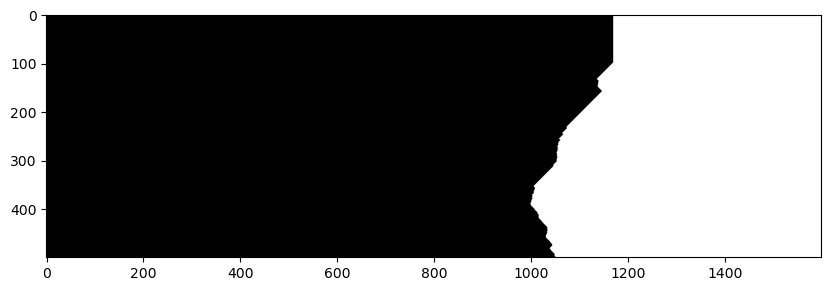

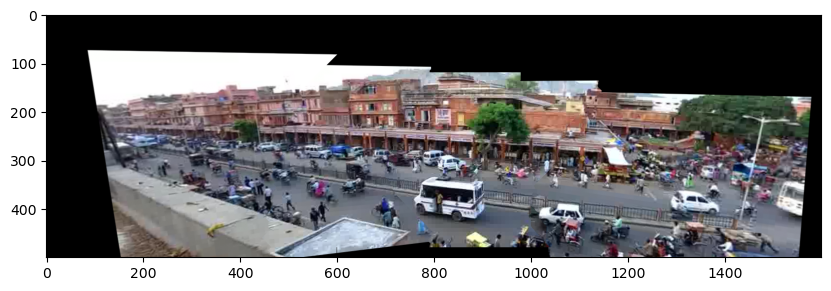

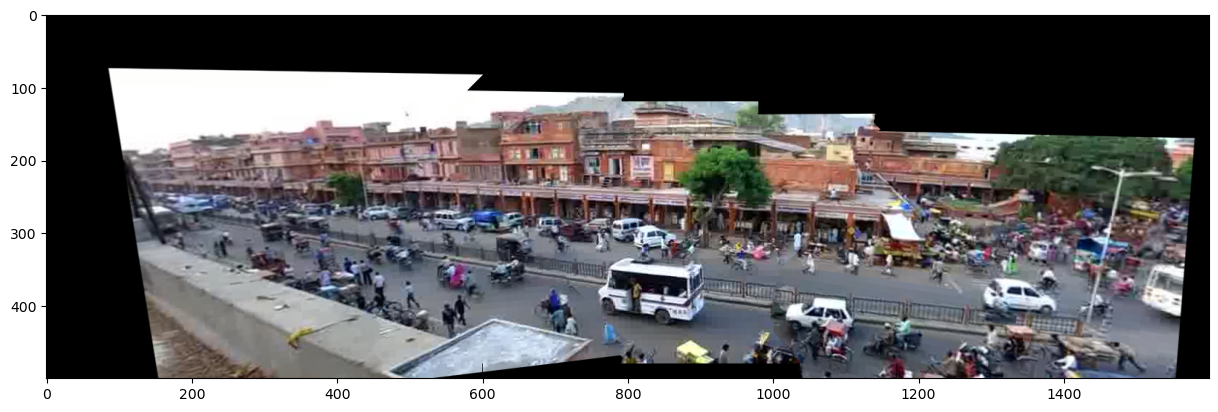

In [262]:
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)


projs = np.zeros((5, projectedHeight, projectedWidth, 3))
projs[0] = cv2.warpPerspective(frames[0], Tr.dot(H02), (projectedWidth, projectedHeight))
projs[1] = cv2.warpPerspective(frames[1], Tr.dot(H12), (projectedWidth, projectedHeight))
projs[2] = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
projs[3] = cv2.warpPerspective(frames[3], Tr.dot(H32), (projectedWidth, projectedHeight))
projs[4] = cv2.warpPerspective(frames[4], Tr.dot(H42), (projectedWidth, projectedHeight))


start = 0
end = projs.shape[0]
old_blend = projs[start]
print("Old Blend iinitial", np.max(old_blend))
for i in range(start+1,end):
  # plt.figure(figsize=(10,10))
  # plt.imshow(old_blend[:,:,[2,1,0]])
  projs[i,0:100,410+190*i,:] = 1
  projs[i,-20:-1,410+190*i,:] = 1
  # print("new image", np.max(projs[i]))
  blend = blend_smooth(projs[i], old_blend)
  old_blend = blend*255
  # print("Old Blend", np.max(old_blend))
  plt.figure(figsize=(10,10))
  plt.imshow(blend[:,:,[2,1,0]])

plt.figure(figsize=(15,15))
plt.imshow(blend[:,:,[2,1,0]])
